In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from mpl_toolkits.mplot3d import Axes3D
import cmath

In [2]:
tau = 0
sol = scipy.sparse.linalg.lsmr(np.identity(3), np.ones(3,), damp = tau)

def min_gen_eigenpair(A = np.identity(3), B = np.identity(3), tau = 0, W0 = np.zeros((3,1))):

    def normal_eqn(x):
        return A.T@(A@x) + (tau**2)*x

    X = scipy.sparse.linalg.LinearOperator(A.shape, matvec=normal_eqn)

    min_eigenpair = scipy.sparse.linalg.lobpcg(X, W0, B=B, largest=False)
    return min_eigenpair

def svd_lsqr(A = np.identity(3),b=np.ones(3,), tau = 0):
    U, S, VT = np.linalg.svd(A)
    S_inv = np.diag(1/(S**2 + tau**2))
    S_mat = np.zeros(A.shape)
    for i in range(0,np.min(A.shape)):
        S_mat[i,i] = S[i]
    return VT.T@S_inv@S_mat.T@U.T@b


In [3]:
def cart2pol(z):
    r = np.sqrt(z[0]**2 + z[1]**2)
    theta = np.arctan2(z[1], z[0])
    return(r, theta)

def pol2cart(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return(x, y)

def RBF(z, mu,sigma):
    return scipy.stats.multivariate_normal.pdf(z, mean = mu, cov = sigma)

def Del_RBF(z, mu,sigma):
    x = np.linalg.solve(sigma,z - mu)
    return RBF(z, mu, sigma)*( np.dot(x,x) - np.sum( 1/np.diag(sigma) ) )

def RNN(z, mean, Cov, W):
    f = np.zeros(W.size)
    for k in range(0,W.size):
        f[k] = RBF(z,mu=mean[k],sigma=Cov[k])
    return np.dot(W,f)

def sigmoid(z,b,C):
    return np.tanh( np.dot(C,z) + b )

def laplace_sigmoid(z,b,C):
    return -2*np.tanh( np.dot(C,z) + b ) / (np.cosh( np.dot(C,z) + b )**2)

def RNN_sigmoid(z, b, C, W):
    f = np.zeros(W.size)
    for k in range(0,W.size):
        f[k] = sigmoid(z,b[k],C[:,k])
    return np.dot(W,f)

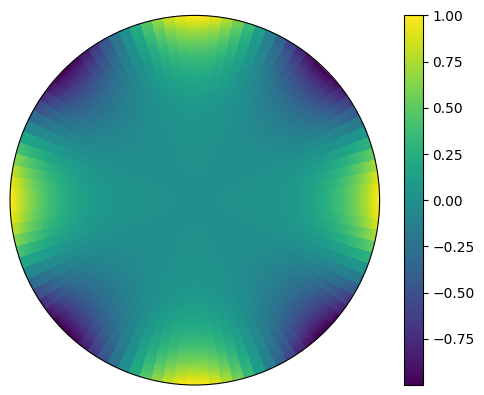

/var/folders/62/pyj4mksx1rxgz6vxbrnwsb1h0000gp/T/ipykernel_13203/1718149817.py:73: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(projection="polar")


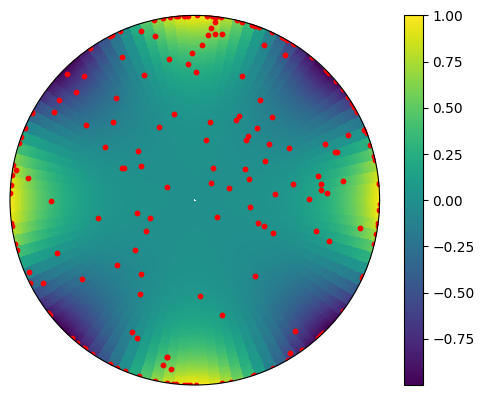

/var/folders/62/pyj4mksx1rxgz6vxbrnwsb1h0000gp/T/ipykernel_13203/1718149817.py:90: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(projection="polar")


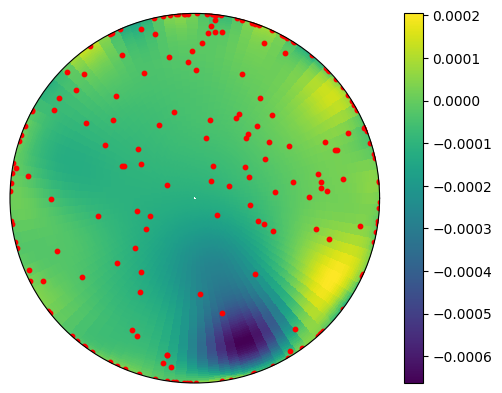

In [4]:
fig = plt.figure()
ax = Axes3D(fig)

rad = np.linspace(0, 1, 100)
azm = np.linspace(0, 2 * np.pi, 100)
r, th = np.meshgrid(rad, azm)
analytic_sol = np.cos(4*th)*rad**4

plt.subplot(projection="polar")
c = plt.pcolormesh(th, r, analytic_sol)
plt.plot(azm, r, color='k', ls='none')
ax=plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid(False)
plt.colorbar(c, ax=ax)
plt.savefig('Poisson_problem_analytic.eps', format='eps')

plt.show()

N = 100
bias = 2
lam = 1e-6
ell = 100

C = np.random.rand(N,2) - 0.5
for k in range(0,N):
    C[k,:] = C[k,:] / np.linalg.norm(C[k,:])
b = (np.random.rand(N,) - 0.5)*2*bias

def Dtanh(z):
    return -2*np.tanh(z)/(np.cosh(z)**2)

def h(z):
    num = complex(z[0],z[1])
    r, theta = cmath.polar(num)
    return np.cos(4*theta)

theta1 = 2*np.pi*np.random.rand(ell)
r1 = np.sqrt(np.random.rand(ell))
z1 = r1*np.cos(theta1) , r1*np.sin(theta1)
z1 = np.asarray(z1)

theta2 = 2*np.pi*np.random.rand(ell)
z2 = np.cos(theta2) , np.sin(theta2)
z2 = np.asarray(z2)

targets = np.zeros((1,2*ell))
for k in range(0,ell):
    targets[0,k+ell] = h(z2[:,k])
   
states = np.zeros((N,2*ell))
for k in range(0,ell):
    states[:,k] = Dtanh(C@z1[:,k] + b)
    states[:,k+ell] = np.tanh(C@z2[:,k] + b)
   
W = svd_lsqr(states.T,targets.reshape(2*ell,), tau=lam)
W_lsmr = scipy.sparse.linalg.lsmr(states.T, targets.reshape(2*ell,), damp = lam)[0]

diff = np.reshape(W@states - targets, (2*ell,))

z = np.zeros(2,)
val = np.zeros((100,100))
for j in range(0,100):
    for k in range(0,100):
        z[0] = rad[j]*np.cos(azm[k])
        z[1] = rad[j]*np.sin(azm[k])
        val[k,j] = W@np.tanh(C@z+b)
   
fig = plt.figure()
ax = Axes3D(fig)
plt.gca().set_xticks([])
plt.subplot(projection="polar")
c = plt.pcolormesh(th, r, val)
plt.plot(azm, r, color='k', ls='none')
plt.grid(False)
plt.scatter(theta1,r1,color='r',s=10)
plt.scatter(theta2,np.ones(ell,),color='r',s=10)
ax=plt.gca()
ax.set_ylim([0,1])
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.colorbar(c, ax=ax)
plt.savefig('Poisson_problem_NN.eps', format='eps')
plt.show()

fig = plt.figure()
ax = Axes3D(fig)
plt.gca().set_xticks([])
plt.subplot(projection="polar")
c = plt.pcolormesh(th, r, val-analytic_sol)
plt.plot(azm, r, color='k', ls='none')
plt.grid(False)
plt.scatter(theta1,r1,color='r',s=10)
plt.scatter(theta2,np.ones(ell,),color='r',s=10)
ax=plt.gca()
ax.set_ylim([0,1])
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.colorbar(c, ax=ax)
plt.savefig('Poisson_problem_diff.eps', format='eps')
plt.show()

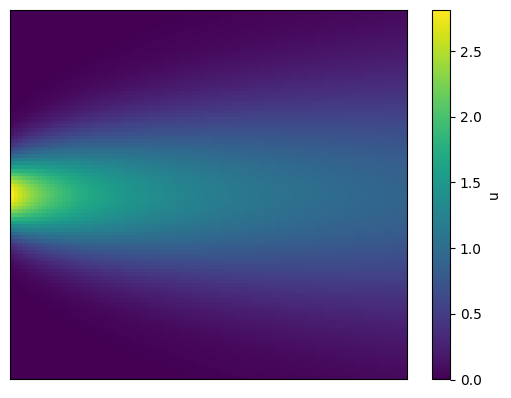

In [5]:
#Heat equation in 1D

# Define the function
def u(x, t):
    return np.exp((-x**2) / (4*t)) / (np.sqrt(4*np.pi*t))

# Generate theta and r values
x = np.linspace(-1, 1, 100)
t = np.linspace(0.01, 0.1, 100)

# Create a meshgrid for polar coordinates
x_mesh, t_mesh = np.meshgrid(x, t)

# Calculate the function values
z = u(x_mesh, t_mesh)

# Plot the polar heatmap
plt.pcolormesh(t_mesh, x_mesh, z, cmap='viridis')
plt.colorbar(label='u')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

In [6]:
# heat equation - random neural network solution

# generate random sample points IID random deviates

# generate random scales and bias

# create matrices

# solve

# plot RNN solution

# plot comparison

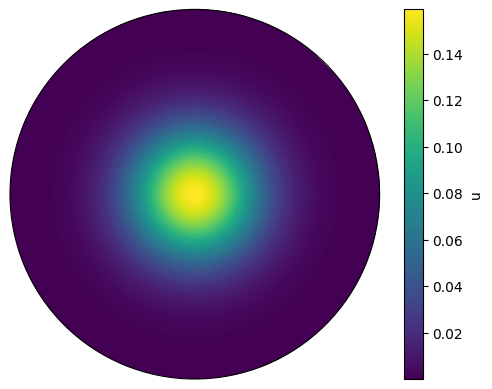

In [7]:
#Stationary state OU

# Define the function
def u(theta, r):
    return np.exp(-r**2 / 2) / (2*np.pi)

# Generate theta and r values
theta = np.linspace(0, 2*np.pi, 100)
r = np.linspace(0, 4, 100)

# Create a meshgrid for polar coordinates
theta_mesh, r_mesh = np.meshgrid(theta, r)

# Calculate the function values
z = u(theta_mesh, r_mesh)

# Plot the polar heatmap
plt.subplot(projection="polar")
plt.pcolormesh(theta_mesh, r_mesh, z, cmap='viridis')
plt.colorbar(label='u')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

In [8]:
# Stationary state OU - random neural network solution

# generate random sample points using mixing trajectory

# generate random scales and bias

# create matrices

# solve

# plot RNN solution

# plot comparison

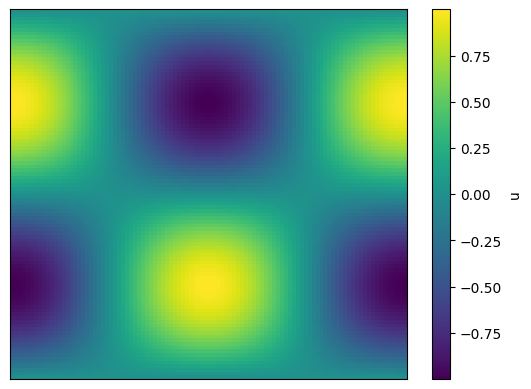

In [9]:
#Wave on string

# Define the function
def u(x, t):
    return np.sin(x)*np.cos(t)

# Generate theta and r values
x = np.linspace(-np.pi, np.pi, 100)
t = np.linspace(0, 2*np.pi, 100)

# Create a meshgrid for polar coordinates
x_mesh, t_mesh = np.meshgrid(x, t)

# Calculate the function values
z = u(x_mesh, t_mesh)

# Plot the polar heatmap
plt.pcolormesh(t_mesh, x_mesh, z, cmap='viridis')
plt.colorbar(label='u')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
# Stationary state OU - random neural network solution

# generate random sample points

# generate random scales and bias

# create matrices

# solve

# plot RNN solution

# plot comparison

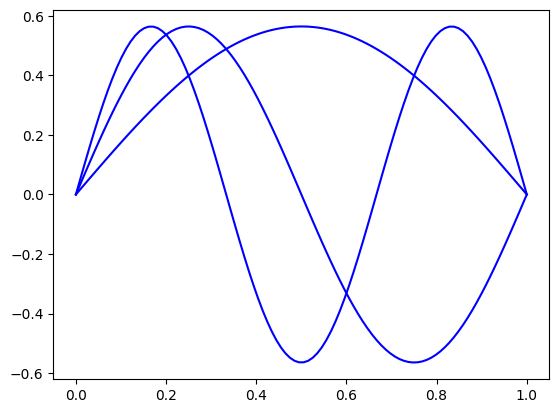

In [11]:
#Schrodinger 

# Define the function
def u(x, n):
    return np.sin(n*np.pi*x) / np.sqrt(np.pi)

# Generate theta and r values
x = np.linspace(0, 1, 100)

plt.plot(x,u(x,1), color = "blue")
plt.plot(x,u(x,2), color = "blue")
plt.plot(x,u(x,3), color = "blue")
plt.show()

In [12]:
# Schrodinger - random neural network solution

# generate random sample points

# generate random scales and bias

# create matrices

# for energies in range 0.1 - 10
    # solve

# plot minimal solution against energy

# plot RNN solution on top of analytic